# Spatial biases

In [35]:
%load_ext autoreload
%autoreload 2

In [36]:
from warnings import warn

import os
import cf_xarray as cfxr
import cordex as cx
import dask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.source import get_source_collection, open_and_sort
from evaltools.utils import short_iid
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

dask.config.set(scheduler="single-threaded")

time_range_default = slice("1981", "2000")
xarray_open_kwargs = {"use_cftime": True, "decode_coords": "all", "chunks": None}

In [37]:
client = Client(dashboard_address="localhost:8000", threads_per_worker=1)
client

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44613 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44613/status,
Dashboard: http://127.0.0.1:44613/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39991,Workers: 16
Dashboard: http://127.0.0.1:44613/status,Total threads: 16
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:33695,Total threads: 1
Dashboard: http://127.0.0.1:34463/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:33615,


In [38]:
vertices = {'CMIP6': ("vertices_lon", "vertices_lat"),
            'CMIP5': ("lon_vertices", "lat_vertices")}

def add_bounds(ds, mip_era = 'CMIP6'):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        ds = cx.transform_bounds(ds, trg_dims=vertices[mip_era])
        ds = ds.assign_coords(
            lon_b=cfxr.bounds_to_vertices(
                ds[vertices[mip_era][0]], bounds_dim="vertices", order="counterclockwise"
            ),
            lat_b=cfxr.bounds_to_vertices(
                ds[vertices[mip_era][1]], bounds_dim="vertices", order="counterclockwise"
            ),
        )
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        source = [ds.attrs[attr] for attr in ['source_id', 'model_id', 'source'] if attr in ds.attrs]
        warn(f"sftlf not found in dataset: {source[0]}")
    return ds


def open_datasets(variables, frequency="mon", driving_source_id="ERA5", 
                  mask=True, add_missing_bounds=False, **kargs):
    catalog = get_source_collection(variables, frequency, driving_source_id,
                                    add_fx=["areacella", "sftlf"])
    dsets = open_and_sort(catalog, merge=merge, concat=False, 
                          time_range = kargs.get("time_range", None))
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for dset_id, ds in dsets.items():
            if driving_source_id == 'ERA5':
                dsets[dset_id] = add_bounds(ds, mip_era='CMIP6')
            elif driving_source_id == 'ECMWF-ERAINT':
                dsets[dset_id] = add_bounds(ds, mip_era='CMIP5')                
    return dsets

def create_cordex_grid(domain_id, mip_era = 'CMIP6'):
    grid = cx.domain(domain_id, bounds=True, mip_era=mip_era)
    # grid["lon"].attrs = {}
    # grid["vertices_lat"].attrs = {}
    lon_b = cfxr.bounds_to_vertices(
        grid[vertices[mip_era][0]], bounds_dim="vertices", order="counterclockwise"
    )
    lat_b = cfxr.bounds_to_vertices(
        grid[vertices[mip_era][1]], bounds_dim="vertices", order="counterclockwise"
    )
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder):
    ds_regrid = regridder(ds)
    for var in ds.data_vars:
        if var not in ["mask", "sftlf"]:
            #continue
            ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"] > 0.0)
    return ds_regrid


def regrid_dsets(dsets, target_grid, method="bilinear"):
    for dset_id, ds in dsets.items():
        try:
            mapping = ds.cf["grid_mapping"].grid_mapping_name
        except Exception as e:
            prin("problmes with grid_mapping definition")
            continue
        if mapping == "rotated_latitude_longitude":
            dsets[dset_id] = ds.cx.rewrite_coords(coords="all")
        else:
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid, method=method)
            print(regridder)
            dsets[dset_id] = regrid(ds, regridder)
    return dsets
    
def mask_invalid(ds, vars=None, threshold=0.1):
    if isinstance(vars, str):
        vars = [vars]
    if vars is None:
        var = list(ds.data_vars)
    for var in vars:
        var_nan = ds[var].isnull().sum(dim="time") / ds.time.size
        ds[var] = ds[var].where(var_nan < threshold)
    return ds

In [39]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (
        (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)
    )

In [40]:
def convert_celsius_to_kelvin(ds, threshold=200):
    """
    Converts all temperature variables in an xarray Dataset from degrees Celsius to Kelvin
    based on the 'units' attribute, value magnitude, or 'standard_name' attribute.

    Parameters:
        ds (xarray.Dataset): The input dataset.
        threshold (float): A heuristic threshold (default=200) to assume temperatures 
                           below this value might be in Celsius.

    Returns:
        xarray.Dataset: A new dataset with converted temperature values.
    """
    ds = ds.copy()  # Avoid modifying the original dataset

    for var in ds.data_vars:
        units = ds[var].attrs.get("units", "").lower()
        standard_name = ds[var].attrs.get("standard_name", "").lower()

        # Check if units explicitly indicate Celsius
        if units in ["c", "°c", "celsius", "degc"]:
            ds[var] = ds[var] + 273.15 
            ds[var].attrs["units"] = "K"
            print(f"Convert celsius to kelvin")
        
        # If no unit attribute exists, check standard_name for temperature-related terms
        elif standard_name in ["air_temperature", "sea_surface_temperature", "surface_temperature"]:
            data_vals = ds[var].values
            if np.nanmax(data_vals) < threshold:  # Likely in °C
                ds[var] = ds[var] + 273.15
                ds[var].attrs["units"] = "K"
                print(f"Convert celsius to kelvin")
                
    return ds

In [41]:
def check_equal_period(ds, period):
    years_in_ds = np.unique(ds.time.dt.year.values)
    expected_years = np.arange(int(period.start), int(period.stop)+1) 
    return np.array_equal(years_in_ds, expected_years)

In [51]:
var_dic = {
    'tas': {'variable': 'tas', 'name': 'Temperature BIAS [K]', 
            'diff': 'abs', 'range':[-4, 4], 'aggr': 'mean', 
            'levels': np.arange(-5, 6, 1), 'cmap' : "RdBu_r",
            'units': "C"},
    'pr': {'variable': 'pr', 'name': 'Precipitation BIAS [%]', 
           'diff': 'rel', 'range':[-60, 180], 'aggr': 'mean',
            'levels': np.arange(-70, 110, 10), 'cmap' : "BrBG",
            'units': '%'}
}

In [52]:
mip_era = 'CMIP6'
variable = 'psl'
frequency = 'mon'
domain = "EUR-11"
regridding = "bilinear"
driving_source_id = 'ERA5'
period = slice("1989", "2008")

In [53]:
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'plots'))

In [54]:
default_attrs = [
        "project_id",
        "domain_id",
        "institution_id",
        "driving_source_id",
        "driving_experiment_id",
        "driving_variant_label",
        "source_id",
        "version_realization",
        'frequency',
        'variable_id',
        "version"
]

In [55]:
# Define how to merge the files in xarray
if driving_source_id == 'ERA5':
    merge = ["variable_id", "frequency"]
elif driving_source_id == 'ECMWF-ERAINT':
    merge = ["variable_id", "frequency", "driving_variant_label", "version"]
default_attrs = [d for d in default_attrs if not d in merge]

In [56]:
dsets = open_datasets([variable], frequency=frequency, driving_source_id = driving_source_id,
                     mask=True, add_missing_bounds=False, 
                      **{'merge': merge, 'time_range': period})

Found: ['ALARO1-SFX', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E'] for variables: ['psl']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.variable_id.version'


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_o

Found 13 datasets
merging: CORDEX.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.v20240920
merging: CORDEX.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.v20250116
merging: CORDEX.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.v20241205
merging: CORDEX.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.v20241216
merging: CORDEX.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.v20241009


In [57]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [58]:
for dset in dsets.keys():
    dsets[dset] = convert_celsius_to_kelvin(dsets[dset])

In [59]:
rotated_grid = create_cordex_grid(domain, mip_era=mip_era)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.v20250116 with grid_mapping: latitude_longitude
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.v20241205 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.v20241009 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:          

In [62]:
if variable == 'psl':
    era5 = xr.open_zarr(
        "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
        chunks={'time': 48},
        consolidated=True,
    )
    era5 = era5[["mean_sea_level_pressure"]]
    era5 = era5.resample(time = 'MS').mean()
    era5 = era5.sel(time=period)
    regridder = xe.Regridder(era5, rotated_grid, method=regridding, unmapped_to_nan=True)
    ref_on_rotated = regridder(era5)

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


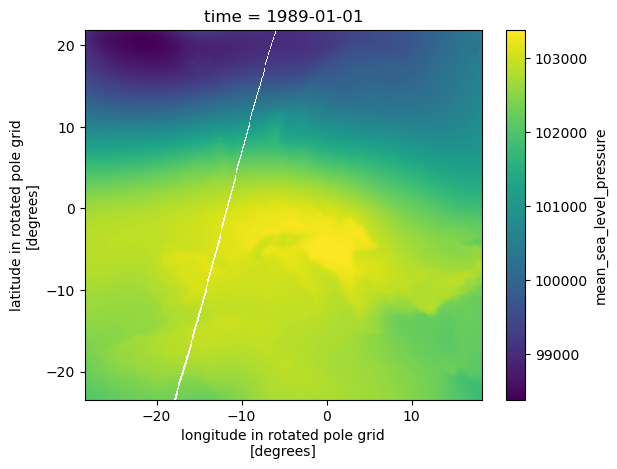

In [64]:
ref_on_rotated['mean_sea_level_pressure'].isel(time = 0).plot()

In [27]:
eobs = obs.eobs(variable, add_mask=False).sel(time=period)
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)

In [29]:
#eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)

NameError: name 'rotated_grid' is not defined

In [18]:
%%time
ref_seasmean = seasonal_mean(ref_on_rotated[eobs_var].sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.47 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3.06 s, sys: 595 ms, total: 3.65 s
Wall time: 17.2 s


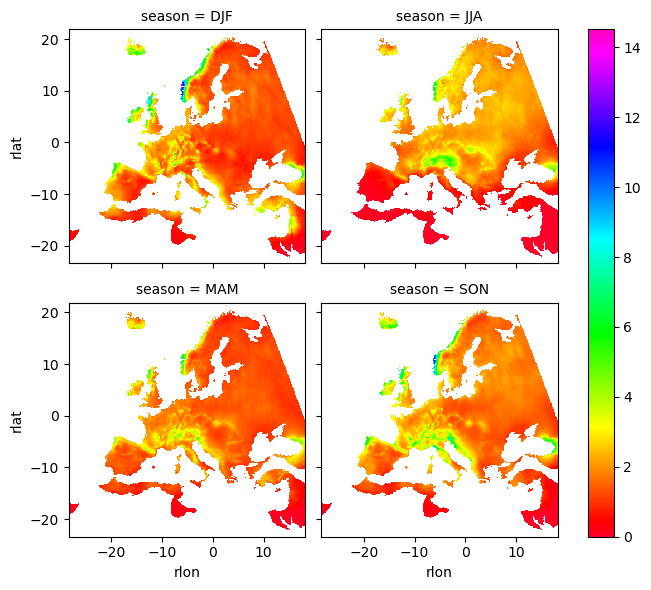

In [19]:
if variable == 'tas':
    cmap = 'jet'
elif variable == 'pr':
    cmap = 'gist_rainbow'
ref_seasmean.plot(col="season", col_wrap=2, cmap = cmap)

In [20]:
if variable == 'tas':
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean + 273.15)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }
elif variable == 'pr':
    diffs = {
        dset_id: 100*(seasonal_mean(ds[[variable]].sel(time=period)).compute()*86400 - (ref_seasmean))/(ref_seasmean)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }

seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id"], default_attrs = default_attrs), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:700: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  unused_keys = set(attribute.keys()) - set(inverted)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:701: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for key, value in attribute.items():
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:709: FutureWarning: The return type of `Dataset.dims` will b

0 0 0 DJF ICON-CLM-202407-1-1
0 1 4 DJF CNRM-ALADIN64E1
0 2 8 DJF REMO2020
0 3 12 DJF HCLIM43-ALADIN
0 4 16 DJF RACMO23E
0 5 20 DJF ALARO1-SFX
1 0 1 JJA ICON-CLM-202407-1-1
1 1 5 JJA CNRM-ALADIN64E1
1 2 9 JJA REMO2020
1 3 13 JJA HCLIM43-ALADIN
1 4 17 JJA RACMO23E
1 5 21 JJA ALARO1-SFX
2 0 2 MAM ICON-CLM-202407-1-1
2 1 6 MAM CNRM-ALADIN64E1
2 2 10 MAM REMO2020
2 3 14 MAM HCLIM43-ALADIN
2 4 18 MAM RACMO23E
2 5 22 MAM ALARO1-SFX
3 0 3 SON ICON-CLM-202407-1-1
3 1 7 SON CNRM-ALADIN64E1
3 2 11 SON REMO2020
3 3 15 SON HCLIM43-ALADIN
3 4 19 SON RACMO23E
3 5 23 SON ALARO1-SFX


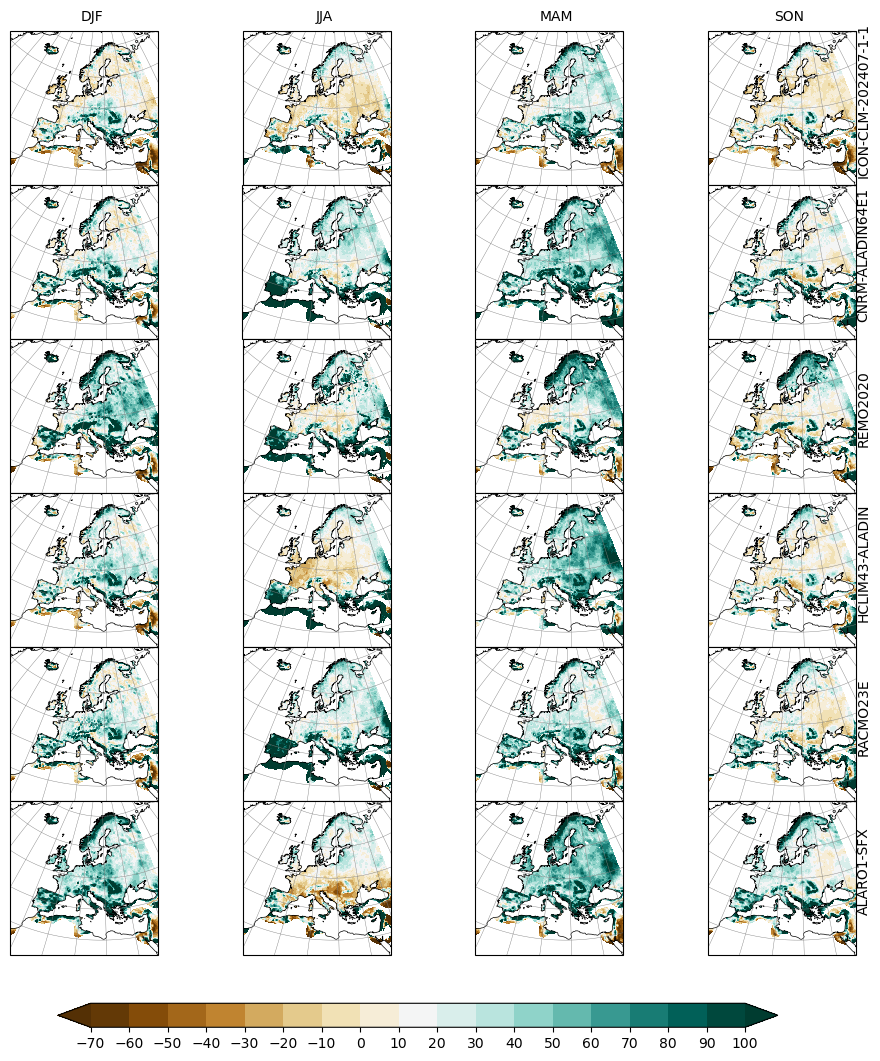

In [21]:
ds = seasonal_bias.copy()

nrows = ds.dset_id.size
ncols = ds.season.size

aspect = ds.cf.dims["Y"] / ds.cf.dims["X"]

# ds = diffs.where(~diffs.isnull(), drop=True)
# pole = ds.cf["grid_mapping"]
# transform = ccrs.RotatedPole(
#    pole_latitude=pole.grid_north_pole_latitude,
#    pole_longitude=pole.grid_north_pole_longitude,
# )
transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
projection = transform

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    subplot_kw={"projection": projection},
    figsize=(12, 12),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0, "hspace": 0},
    #  aspect_ratio=0.97,
)

# plt.subplots_adjust(wspace=0, hspace=0)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()

# Loop over all of the models
for i, season in enumerate(['DJF', 'JJA', 'MAM', 'SON']):
    for j, dset_id in enumerate(ds.dset_id.values):
        pos = i + j * ncols
        print(i, j, pos, season, dset_id)
        # Select the week 1 forecast from the specified model
        data = ds[variable].isel(season=i, dset_id=j)

        # Add the cyclic point
        # data,lons=add_cyclic_point(data,coord=ds['lon'])

        # Contour plot
        cs = axs[pos].contourf(
            ds.cf["X"],
            ds.cf["Y"],
            data,
            transform=transform,
            # Define the levels for contourf
            levels=var_dic[variable]['levels'],
            #cmap=cmap,
            extend="both",
            # vmin=-8, vmax=8,
            cmap=var_dic[variable]['cmap'],
            #norm=norm,
        )

        # if i == 3:
        #    axs[pos].set_ylabel(dset_id)

        axs[pos].set_aspect(round(aspect, 3))

        # Title each subplot with the name of the model
        # axs[pos].set_title(pos)

        # Draw the coastines for each subplot
        axs[pos].coastlines(resolution="50m", color="black", linewidth=0.5)

        gl = axs[pos].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )

        # axs[pos].xaxis.set_tick_position('bottom')
        # axs[pos].yaxis.set_tick_position('left')

        # Longitude labels
        # https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
        if i == 3:
            axs[pos].text(
                1.1,
                0.55,
                dset_id,
                va="bottom",
                ha="center",
                rotation="vertical",
                rotation_mode="anchor",
                transform=axs[pos].transAxes,
            )
        if j == 0:
            axs[pos].text(
                0.55,
                1.05,
                season,
                va="bottom",
                ha="center",
                rotation="horizontal",
                rotation_mode="anchor",
                transform=axs[pos].transAxes,
            )
        # if i == 0:
        # axs[pos].set_title(season)
        #    axs[pos].set_xlabel(dset_id)
        #    axs[pos].set_xticks(range(-180, 180, 10), crs=ccrs.PlateCarree())
        # lon_formatter = cticker.LongitudeFormatter()
        # axs[i].xaxis.set_major_formatter(lon_formatter)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[pos].xaxis.set_major_formatter(lon_formatter)
        axs[pos].yaxis.set_major_formatter(lat_formatter)
        # # Latitude labels
        # axs[pos].set_yticks(range(-90, 90, 10), crs=ccrs.PlateCarree())
        # lat_formatter = cticker.LatitudeFormatter()
        # axs[i].yaxis.set_major_formatter(lat_formatter)

# Adjust the location of the subplots on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.08, hspace=0.08)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal", ticks = var_dic[variable]['levels'])

plt.subplots_adjust(wspace=0, hspace=0)


# Add a big title at the top
# plt.suptitle('SubX Week 1 2m Temperature Anomalies ($^\circ$C): Apr 16, 2020 Initialized Forecasts')

## For DJF and JJA

In [ ]:
for season in ["DJF", "JJA"]:
    ds = seasonal_bias.copy()
    
    nrows =  int(np.ceil(len(seasonal_bias.dset_id)/5))
    ncols = 5
    
    aspect = ds.cf.dims["Y"] / ds.cf.dims["X"]
    
    transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
    projection = transform
    
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": projection},
        figsize=(12, 6),
        gridspec_kw={"wspace": 0, "hspace": 0},
        #  aspect_ratio=0.97,
    )

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs = axs.flatten()
    
    # Loop over all of the models
    for pos, dset_id in enumerate(ds.dset_id.values):
        print(pos, season, dset_id)
        # Select the week 1 forecast from the specified model
        data = ds[variable].isel(season=np.where(ds.season==season)[0][0], dset_id=pos)
    
        # Contour plot
        cs = axs[pos].contourf(
            ds.cf["X"],
            ds.cf["Y"],
            data,
            transform=transform,
            # Define the levels for contourf
            levels=var_dic[variable]['levels'],
            extend="both",
            cmap=var_dic[variable]['cmap'],
            #norm=norm,
        )
    
        axs[pos].set_aspect(round(aspect, 3))
    
        # Title each subplot with the name of the model
        axs[pos].set_title(dset_id, loc='center', pad=-20)
    
        # Draw the coastines for each subplot
        axs[pos].coastlines(resolution="50m", color="black", linewidth=0.5)
    
        gl = axs[pos].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )
    
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[pos].xaxis.set_major_formatter(lon_formatter)
        axs[pos].yaxis.set_major_formatter(lat_formatter)

    # Ocultar los subplots sobrantes
    for i in range(len(seasonal_bias.dset_id), nrows * ncols):  
        axs[i].set_visible(False)  # Oculta los subplots vacíos

    # Agregar la colorbar en el margen izquierdo
    cbar_ax = fig.add_axes([0, 0.15, 0.02, 0.7]) 
    cbar = fig.colorbar(cs, cax=cbar_ax, orientation="vertical", ticks=var_dic[variable]['levels'])
    cbar_ax.set_title(f"[{var_dic[variable]['units']}]")
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.set_label(season, fontsize = 12)
        
    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    
    # Add a big title at the top
    # plt.suptitle('SubX Week 1 2m Temperature Anomalies ($^\circ$C): Apr 16, 2020 Initialized Forecasts')
    plt.savefig(f"{save_figure_path}/{mip_era}_eobs_{variable}_{season}_{period.start}-{period.stop}.png", bbox_inches='tight', transparent=True, pad_inches=0)

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:700: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  unused_keys = set(attribute.keys()) - set(inverted)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:701: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for key, value in attribute.items():
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:709: FutureWarning: The return type of `Dataset.dims` will b

0 DJF ICON-CLM-202407-1-1
1 DJF CNRM-ALADIN64E1
2 DJF REMO2020
3 DJF HCLIM43-ALADIN
4 DJF RACMO23E
5 DJF ALARO1-SFX


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:700: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  unused_keys = set(attribute.keys()) - set(inverted)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:701: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for key, value in attribute.items():
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:709: FutureWarning: The return type of `Dataset.dims` will b

0 JJA ICON-CLM-202407-1-1
1 JJA CNRM-ALADIN64E1
2 JJA REMO2020
3 JJA HCLIM43-ALADIN
4 JJA RACMO23E
5 JJA ALARO1-SFX
